# Classification and Regression with a Neural Network in Pytorch

Welcome to your first programming assignment! 
In this assignment you will build your first classification and regression neural networks.
This assignment is a 'step-through' guide to implement a simple fully-connected neural network in Pytorch.

* In the first part of this exercise, you will implement a neural network with a 2 dimensional input. Your dataset is based on a two <a href=https://en.wikipedia.org/wiki/Crescent> crescent </a> moon-shaped groups for classification.

* Then, in the second part of this exercise, you will implement a regression model for predicting the output of a two dimensional function.

# Packages
Let's first import all the packages that you will need during this part of assignment.

Feel free to use another libraries if you want to.

In [28]:
import numpy as np
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import torch
from torch import nn

# Dataset

In [29]:
id_num_str = input("Please Enter your Israeli ID?")
if (len(id_num_str) != 9):
    print('ID should contain 9 digits')
if (id_num_str.isdigit() is False):
    print('ID should contain only digits')
id_num = list(id_num_str[-3:])
random_num = sum(list(map(int, id_num)))
random_num

Please Enter your Israeli ID?123456789


24

In [30]:
np.random.seed(random_num)
torch.manual_seed(random_num)
x, y = make_moons(500, noise=0.2, random_state = random_num)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_num)

**Visualize the dataset using matplotlib:**

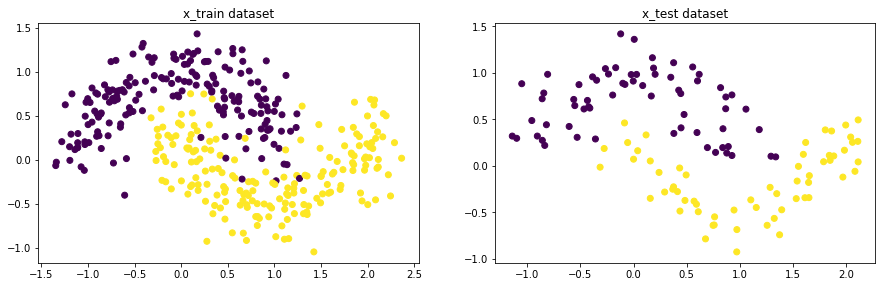

In [31]:
### START CODE HERE ###
plt.figure(figsize=(15, 15))


plt.subplot(321)
plt.title("x_train dataset")
plt.scatter(x_train[:,0] , x_train[:,1] , c=y_train)


plt.subplot(322)
plt.title("x_test dataset")
plt.scatter(x_test[:,0] , x_test[:,1] , c=y_test)


# Simple Logistic Regression

What you are required to do:

1. Implement a 2-class classification neural network with a zero hidden layer.
2. Plot loss vs epoch.
3. Plot AUC vs epoch for train and test sets. 
4. Plot ROC curve and calculate AUC for the test set.
5. Plot the learned decision boundary.
6. Briefly interpret graph's results.   

How you will do it:

1. Prepare the Data.
2. Define the Model.
3. Train the Model.
4. Evaluate the Model.
5. Visualization.

#### Preprare the Data

In [32]:
# We will use PyTorch classes Dataset and Dataloader in order to feed data
# in batches, and shuffled for training

# In the dataset class we need to give the length and return an element of the data
class MoonsDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()

        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx]

In [33]:
# The dataloader class uses a dataset and serves it on batches
def create_dataloader(X, y, batch_size, shuffle):
    dataset = MoonsDataset(X, y)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)

    return data_loader

# Create a dataloader with the training data
train_dataloader = create_dataloader(x_train, y_train, batch_size=32, shuffle=True)

# Create a dataloader with the test data
test_dataloader = create_dataloader(x_test, y_test, batch_size=32, shuffle=False)

**Define the Model:**

In [34]:
### START CODE HERE ###
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # Linear layer of output size 1 because we are in binary classification
        self.linear = nn.Linear(input_size, 1)
        
        # The sigmoid layer will convert the outputs of the linear layer
        # into a probability
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        x = x.squeeze(dim=-1)
        
        return x

In [35]:
logistic_regression_model = LogisticRegression(input_size=2)

**Training and validation:**

In [36]:
### START CODE HERE ###

# Define training step
def train_step(model, dataloader, optimizer, criterion, metric=None):
    # put the model in training mode
    model.train()

    epoch_loss = 0
    
    if metric is not None:
        metric_score = 0

    # Run over all the dataset in batches
    for step, data in enumerate(dataloader):
        # retrieve data from the current batch
        X, y = data
        
        # we need to zero the gradient of the optimizer in each step
        optimizer.zero_grad()

        # generate predictions
        outputs = model(X)

        # calculate loss
        loss = criterion(outputs, y)

        # backward pass
        loss.backward()
        
        optimizer.step()

        # accumulate loss
        epoch_loss += loss.item()
        
        # accumulate metric
        if metric is not None:
            metric_score += metric(y.numpy(), outputs.detach().numpy())

    # we currently have a sum of the losses, so average them
    epoch_loss /= len(dataloader)
       
    # average metric
    if metric is not None:
        metric_score /= len(dataloader)
       
    # if we provided a metric function, return two outputs (the loss and the metric), else return just the loss
    result = (epoch_loss, metric_score) if metric is not None else epoch_loss
            
    return result

In [37]:
def evaluate(model, dataloader, criterion, metric=False):
    # put the model in evaluation mode
    model.eval()

    epoch_loss = 0
    
    if metric is not None:
        metric_score = 0

    # do not accumualate gradients for tensors during evaluation
    with torch.no_grad():
        for _, data in enumerate(dataloader):
            # retrieve data from current batch
            X, y = data

            # generate predictions
            outputs = model(X)

            # calculate loss
            loss = criterion(outputs, y)

            # accumulate loss
            epoch_loss += loss.item()
            
            # accumulate metric, if any
            if metric is not None:
                metric_score += metric(y.numpy(), outputs.detach().numpy())
                
    # average loss over all the batches
    epoch_loss /= len(dataloader)
       
    # average metric over all the batches
    if metric is not None:
        metric_score /= len(dataloader)
        
    # if we provided a metric function, return two outputs (the loss and the metric), else return just the loss
    result = (epoch_loss, metric_score) if metric is not None else epoch_loss

    return result

In [38]:
def train_model(model, trainloader, validationloader, epochs=2, learning_rate=1e-3, mode='classificaton', metric_function=None, verbose=1):

    print("Training started...")

    # Use Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # We will use binary cross-entropy loss for classification and mean squared error loss for regression
    criterion = torch.nn.BCELoss() if mode == 'classificaton' else torch.nn.MSELoss()

    losses = []
    val_losses = []
        
    if metric_function is not None:
        metric_scores = []
        val_metric_scores = []

    # Train and validate for the number of epoch specified as parameter
    for epoch in range(epochs):
        # perform a training step
        train_loss = train_step(model, trainloader, optimizer, criterion, metric_function)
        if metric_function is not None:
            train_loss, train_metric_score = train_loss

        if (verbose):
            # perform an evaluation step
            val_loss = evaluate(model, validationloader, criterion, metric_function)
            if metric_function is not None:
                val_loss, val_metric_score = val_loss

            print(f'epoch {epoch} loss {train_loss} val_loss {val_loss}')

            # save losses for plotting them later
            losses.append(train_loss)
            val_losses.append(val_loss)
            
            # save metrics for plotting them later
            if metric_function is not None:
                metric_scores.append(train_metric_score)
                val_metric_scores.append(val_metric_score)


    # we will return a dictionary containing the losses
    history = {'loss': losses, 'val_loss': val_losses}
    
    # and also the metrics if there were any
    if metric_function is not None:
        history['metric'] = metric_scores
        history['val_metric'] = val_metric_scores

    return history

In [39]:
history = train_model(logistic_regression_model, train_dataloader, test_dataloader, epochs=100, learning_rate=1e-2, metric_function=roc_auc_score)

Training started...
epoch 0 loss 0.5924546393481168 val_loss 0.5459754963715872
epoch 1 loss 0.5496622730385173 val_loss 0.512236217657725
epoch 2 loss 0.5187374786897139 val_loss 0.4846840997536977
epoch 3 loss 0.48910811001604254 val_loss 0.4632121721903483
epoch 4 loss 0.46607198769396 val_loss 0.44503168265024823
epoch 5 loss 0.44910353422164917 val_loss 0.42973652482032776
epoch 6 loss 0.4412162656133825 val_loss 0.4164558748404185
epoch 7 loss 0.42697450247677887 val_loss 0.4055079718430837
epoch 8 loss 0.4183310730890794 val_loss 0.39584043622016907
epoch 9 loss 0.4080607159571214 val_loss 0.3865563025077184
epoch 10 loss 0.40042819760062476 val_loss 0.37869606415430707
epoch 11 loss 0.3890786956657063 val_loss 0.3714409867922465
epoch 12 loss 0.3825671103867618 val_loss 0.3646013041337331
epoch 13 loss 0.38098129630088806 val_loss 0.3586333592732747
epoch 14 loss 0.3722257912158966 val_loss 0.3529825210571289
epoch 15 loss 0.3755280307748101 val_loss 0.34768080711364746
epoch 1

**Visualizing the plots**:

##### Loss vs epoch

In [40]:
### START CODE HERE ###
def plot_training_history(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

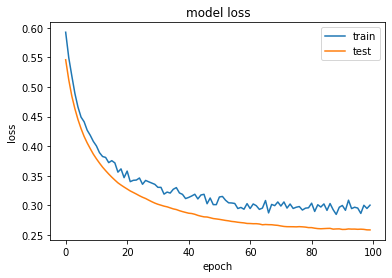

In [41]:
plot_training_history(history)

##### AUC vs epoch

In [42]:
### START CODE HERE ###
def plot_training_metric(history, metric_name):
    plt.plot(history['metric'])
    plt.plot(history['val_metric'])
    plt.title(f'model {metric_name}')
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

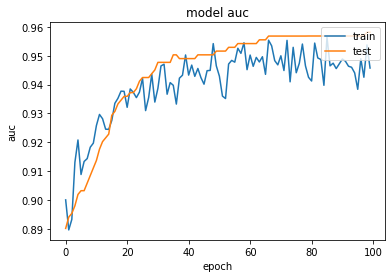

In [43]:
plot_training_metric(history, 'auc')

##### ROC curve

In [44]:
def predict(model, x, return_probabilities=True):
    # Put model in evaluation mode
    model.eval()
    
    # Do not accumulate gradients
    with torch.no_grad():
        
        # Convert x from a numpy array to a PyTorch tensor
        x = torch.from_numpy(x).type(torch.FloatTensor)
        
        # Generate predictions and convert the Tensor back to a numpy array
        predictions = model(x).numpy()
        
        if not return_probabilities:
            # Convert probabilities to the class it pertains by using the threshold 0.5.
            # Probabilities higher than 0.5 will pertain to class 1, and lower than 0.5
            # to the class 0
            predictions = (predictions > 0.5).astype(np.int32)
    return predictions

In [45]:
predictions = predict(logistic_regression_model, x_test)

In [46]:
def plot_roc_curve(targets, predictions):
    # generate false positives and true positives
    fpr, tpr, _ = roc_curve(targets, predictions)
    
    # get the auc score
    roc_auc = auc(fpr, tpr)
    
    # plot the figure
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

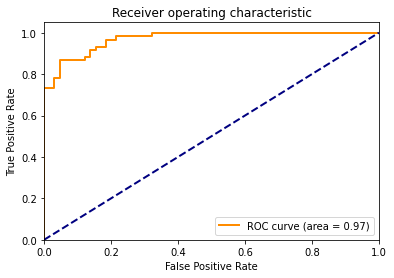

In [47]:
plot_roc_curve(y_test, predictions)

##### AUC for the test set

In [48]:
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
print(f'AUC for the test set: {roc_auc:.4f}')

AUC for the test set: 0.9703


#### Decision boundary

In [49]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole gid
    Z = predict(model, np.c_[xx.ravel(), yy.ravel()], return_probabilities=False)
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)

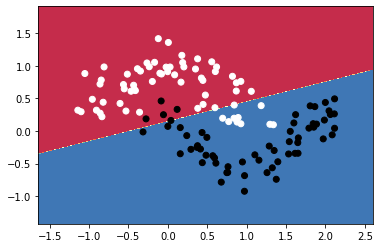

In [50]:
plot_decision_boundary(logistic_regression_model, x_test, y_test)

**Question:** 

Is the decision boundary linear or nonlinear in the case of a logistic regression? Explain.

**Answer:**

The decision boundary is linear, because in logistic regression the output is a linear combination of the inputs (W*X + b), and the sigmoid function is only used to constraint the output to the range 0-1.

# Classification with Neural Networks

After you implemented "classical" logistic regression, now you will be implementing a neural network with one or more hidden layers.
You will need to choose the number of hidden layers and nodes in a feedforward neural network, activation function, the type of optimizer and its hyperparmeters which will give you the best result. Remember, we don't want to overfit the training data, we want to generalize the solution for new data not seen during training. 

Plot the same graphs as in the previous sections and explain the similarities and differences. 

**Define the Model:**

In [58]:
### START CODE HERE ###
class NeuralNetworkClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        # We will stack 3 hidden layers and the output layer
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.output_linear = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))

        x = self.output_linear(x)
        
        x = self.sigmoid(x)
        x = x.squeeze(dim=-1)
        
        return x

In [59]:
neural_network_classifier = NeuralNetworkClassifier(input_size=2)

**Training and validation:**

In [60]:
### START CODE HERE ###
history = train_model(neural_network_classifier, train_dataloader, test_dataloader, epochs=100, learning_rate=1e-3, metric_function=roc_auc_score)

Training started...
epoch 0 loss 0.5135236003182151 val_loss 0.3071369429429372
epoch 1 loss 0.26252289522777905 val_loss 0.19355618953704834
epoch 2 loss 0.2397120710123669 val_loss 0.1699619727830092
epoch 3 loss 0.20378898626024072 val_loss 0.12970474983255068
epoch 4 loss 0.1591577326709574 val_loss 0.11384723832209905
epoch 5 loss 0.14022979885339737 val_loss 0.1060284183671077
epoch 6 loss 0.12683835761113602 val_loss 0.16154658049345016
epoch 7 loss 0.1085502335971052 val_loss 0.04788666342695554
epoch 8 loss 0.11011819439855489 val_loss 0.12688634047905603
epoch 9 loss 0.10149266088212078 val_loss 0.05462663434445858
epoch 10 loss 0.10774277861822736 val_loss 0.03783710300922394
epoch 11 loss 0.12432501871477473 val_loss 0.15838767867535353
epoch 12 loss 0.11440307122062553 val_loss 0.04887424409389496
epoch 13 loss 0.10642229342325167 val_loss 0.04263343537847201
epoch 14 loss 0.10104102014817974 val_loss 0.11752221764375766
epoch 15 loss 0.08747946945103732 val_loss 0.0482136

**Visualizing the plots:**

##### Loss vs epoch

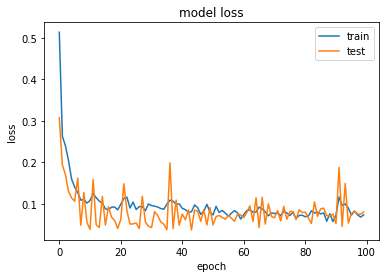

In [61]:
### START CODE HERE ###
plot_training_history(history)

##### AUC vs epoch

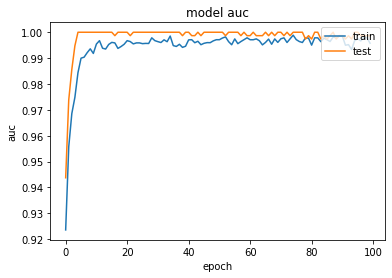

In [62]:
plot_training_metric(history, 'auc')

##### ROC curve

In [63]:
predictions = predict(neural_network_classifier, x_test)

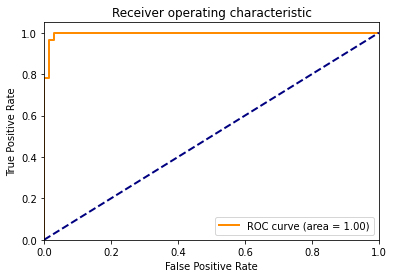

In [64]:
plot_roc_curve(y_test, predictions)

##### AUC for the test set

In [65]:
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
print(f'AUC for the test set: {roc_auc:.4f}')

AUC for the test set: 0.9962


##### Decision boundary

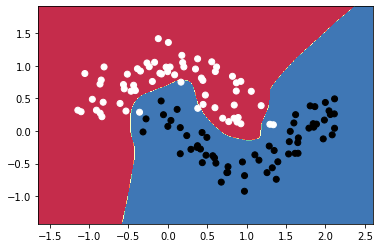

In [66]:
plot_decision_boundary(neural_network_classifier, x_test, y_test)

#### Explain the similarities and differences:

The decision boundary is non-linear, because neural network is a combination of layers, and each layer is composed of a linear combination of the input (W*X + b) and then a non-linear function is applied (ReLU), making the output non-linear. Then this non-linear output is feed to the next layer, until it reaches the sigmoid that will constraint the output to the 0-1 range.

# Regression with Neural Networks

In this part of the excercise you will need to implement a regression model using neural networks. The model should predict the output of a trigonometric function of two variables. Your data set is based on a meshgrid. Your task is to create a list of points that would correspond to a grid and use it for the input of your neural network. Then, build your neural networks and find the architecture which gives you the best results.
1. Plot the surface from the overall data and compare it to your predicted test sets.
2. Which loss function and validation metric did you choose?
3. Plot the loss and validation metrics vs epoch for the training and test sets.
4. Build a new neural network and try overfitting your training set. Show that you managed to overfit. Explain.

# Packages 

First import all the packages that you will need during this part of assignment.

Feel free to use another libraries if you want to.

In [67]:
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import cm

**Generate data:**

In [68]:
np.random.seed(random_num)
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 30)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx) * np.cos(yy) + 0.1 * np.random.rand(xx.shape[0], xx.shape[1])

In [69]:
class MeshGridDataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        np.random.seed(random_num)

    def __len__(self):
        # As we are generating samples, the length of the data is infinite. So
        # use a random amount to let the training procedure know when to end
        # an epoch
        return 500

    def __getitem__(self, idx):
        
        # We will generate a random sample of data everytime
        x = np.linspace(-5, 5, 30)
        y = np.linspace(-5, 5, 30)
        xx, yy = np.meshgrid(x, y)
        z = np.sin(xx) * np.cos(yy) + 0.1 * np.random.rand(xx.shape[0], xx.shape[1])
        
        # Convert the data to float32
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        z = z.astype(np.float32)
        
        return (x, y), z

In [70]:
# Create a dataloader for serving our new dataset in batches
def create_dataloader(batch_size, shuffle, drop_last=True):
    dataset = MeshGridDataset()
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

    return data_loader

In [71]:
train_dataloader = create_dataloader(batch_size=32, shuffle=True, drop_last=False)

In [72]:
test_dataloader = create_dataloader(batch_size=32, shuffle=False, drop_last=False)

**Define the Model:**

In [73]:
### START CODE HERE ###
class NeuralNetworkRegressor(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.linear2 = nn.Linear(128, 64)
        self.output_linear = nn.Linear(64, output_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # We are serving x and y inside the variable x, as a tuple
        # so retrieve them
        _x, _y = x

        # Concatenate both
        x = torch.cat([_x, _y], dim=-1)
        
        # Apply hidden layers
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))

        # Output the predictions, which will be flattened
        # with shape [batch_size, 30*30]
        x = self.output_linear(x)
        
        # So convert the predictions to the original shape
        # of [batch_size, 30, 30]
        x = torch.reshape(x, [-1, 30, 30])
        
        # Remove batch dimension if it was 1 (this happens when feeding a single examaple to the model)
        x = x.squeeze()
        
        return x

In [74]:
neural_network_regressor = NeuralNetworkRegressor(input_size=30*2, output_size=30*30)

**Training and validation:**

In [75]:
def rmse(targets, predictions):
    score = 0.0
    
    # Calculate RMSE over all the batches of data
    N = len(targets)
    for i in range(N):
        target = targets[i]
        prediction = predictions[i]
        score += mean_squared_error(target, prediction, squared=False, multioutput='uniform_average')
    
    score /= N
    
    return score

In [76]:
### START CODE HERE ###
history = train_model(neural_network_regressor, train_dataloader, test_dataloader, epochs=50, learning_rate=1e-4, mode='regression', metric_function=rmse)

Training started...
epoch 0 loss 0.34136655926704407 val_loss 0.29396021366119385
epoch 1 loss 0.26979250460863113 val_loss 0.2488188212737441
epoch 2 loss 0.23735698591917753 val_loss 0.22646433673799038
epoch 3 loss 0.2185246767476201 val_loss 0.20983760990202427
epoch 4 loss 0.20192192401736975 val_loss 0.19268367532640696
epoch 5 loss 0.1836992334574461 val_loss 0.17309238202869892
epoch 6 loss 0.1630307724699378 val_loss 0.15126249473541975
epoch 7 loss 0.14054438471794128 val_loss 0.12839966267347336
epoch 8 loss 0.1178879956714809 val_loss 0.10620210459455848
epoch 9 loss 0.09657469857484102 val_loss 0.08602965576574206
epoch 10 loss 0.07758226152509451 val_loss 0.06842297688126564
epoch 11 loss 0.06122475070878863 val_loss 0.05355951329693198
epoch 12 loss 0.047662981785833836 val_loss 0.04140276974067092
epoch 13 loss 0.03667331952601671 val_loss 0.03174548200331628
epoch 14 loss 0.02801670040935278 val_loss 0.02416209632065147
epoch 15 loss 0.021267972653731704 val_loss 0.018

**Visualizing the plots:**

#### Plot the surface from the overall data and compare it to your predicted test sets

In [77]:
def plot_surface(xx, yy, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

###### Original surface

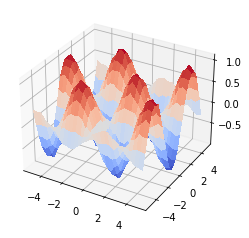

In [78]:
plot_surface(xx, yy, z)

##### Predicted surface

In [79]:
predictions = predict(neural_network_regressor, np.array([x, y]))

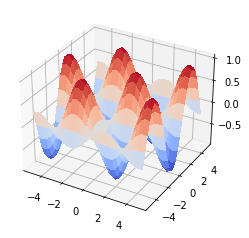

In [80]:
plot_surface(xx, yy, predictions)

#### Which loss function and validation metric did you choose?

For validation, it was chosen Root Mean Squared Error (RMSE), and 
Mean squared error as a loss function. The reason for this is that RMSE does an additional square root operation with respect to MSE (which makes it more computationally expensive), so MSE is more widely used.


#### Plot the loss and validation metrics vs epoch for the training and test sets.

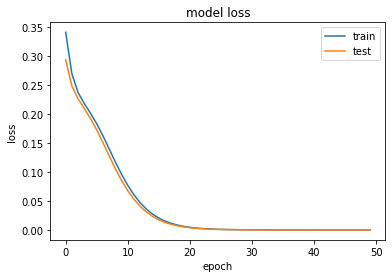

In [81]:
### START CODE HERE ###
plot_training_history(history)

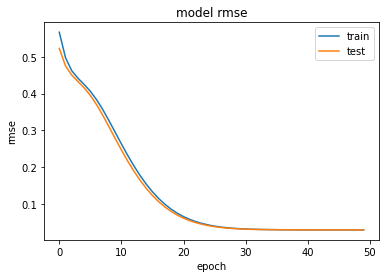

In [82]:
plot_training_metric(history, 'rmse')

### Build a new neural network and try overfitting your training set

**Generate data:**

In [83]:
np.random.seed(random_num)
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 30)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx) * np.cos(yy) + 0.1 * np.random.rand(xx.shape[0], xx.shape[1])

**Define the Model:**

In [84]:
### START CODE HERE ###
class NeuralNetworkRegressor2(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        # The network is like the last one, but using bigger layers, with the
        # idea that the extra parameters will improve the chances of overfitting
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.output_linear = nn.Linear(128, output_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        xx, yy = x

        x = torch.cat([xx, yy], dim=-1)
        
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))

        x = self.output_linear(x)
        
        x = torch.reshape(x, [-1, 30, 30])
        
        return x

In [85]:
neural_network_regressor2 = NeuralNetworkRegressor2(input_size=30*2, output_size=30*30)

**Training and validation:**

In [86]:
### START CODE HERE ###
history = train_model(neural_network_regressor2, train_dataloader, test_dataloader, epochs=50, learning_rate=1e-4, mode='regression', metric_function=rmse)

Training started...
epoch 0 loss 0.24752009473741055 val_loss 0.2319026282057166
epoch 1 loss 0.2149292817339301 val_loss 0.19241114240139723
epoch 2 loss 0.16826704610139132 val_loss 0.13911195192486048
epoch 3 loss 0.11352520110085607 val_loss 0.08623399585485458
epoch 4 loss 0.06636437168344855 val_loss 0.04670873610302806
epoch 5 loss 0.03428154601715505 val_loss 0.022680873051285744
epoch 6 loss 0.016006204998120666 val_loss 0.010039217653684318
epoch 7 loss 0.006965589011088014 val_loss 0.004342089843703434
epoch 8 loss 0.003100450980127789 val_loss 0.0020775898738065735
epoch 9 loss 0.0016255857262876816 val_loss 0.0012559098104247823
epoch 10 loss 0.0010961300358758308 val_loss 0.0009720954512886237
epoch 11 loss 0.0009180629494949244 val_loss 0.0008779253730608616
epoch 12 loss 0.0008631383097963408 val_loss 0.0008500989970343653
epoch 13 loss 0.0008463551130262204 val_loss 0.0008427324901276734
epoch 14 loss 0.0008395217046199832 val_loss 0.0008393739080929663
epoch 15 loss 0

**Visualizing the plots:**

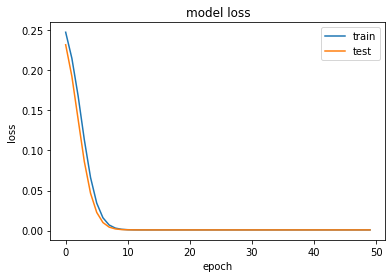

In [87]:
### START CODE HERE ###
plot_training_history(history)

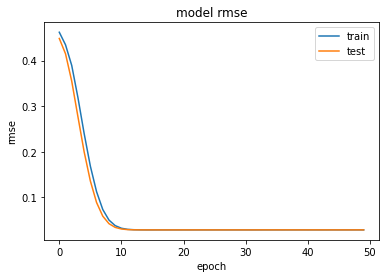

In [88]:
plot_training_metric(history, 'rmse')

5. Briefly explain graph's results.

The model seems to have learnt perfectly the trigonometric function, which can be seen from the train and test curves overlapping.

6. How does your metric value differs between the training data and the test data and why?


The metric values in training and test data are very close, as train and test curves are overlapping. So there are no significant differences between train and test metrics.